In [25]:
import numpy as np
import cv2
import threading
import time
import matplotlib.pyplot as plt

In [67]:
class WebcamVideoStream:
    
    def __init__(self, src=0, api=None):
        self.stream = cv2.VideoCapture(src, api) if api else cv2.VideoCapture(src)
        self.frame = None
        self.stopped = False
        self.frame_counter = []
        
    def start(self):
        threading.Thread(target=self.update, args=()).start()
        return self

    def stop(self):
        self.stopped = True
        self.stream.release()
        
    def update(self):
        while not self.stopped:
            (self.grabbed, self.frame) = self.stream.read()
            self.frame_counter.append(time.time())
            
    def read(self):
        return self.frame

    def get_frame_diffs(self):
        return 1.0/np.diff(np.array(self.frame_counter))
        
    def get_avg_fps(self):
        return self.get_frame_diffs().mean()

In [79]:
class VideoWriter:
    
    def __init__(self, vs):
        self.fps = 30.0
        self.vs = vs
        self.stopped = False
        self.frame_counter = []
        
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.out = cv2.VideoWriter('test_video.avi', fourcc, self.fps, (int(vs.stream.get(3)), int(vs.stream.get(4))))
        
    def start(self):
        self.t_start = time.time()
        threading.Thread(target=self.update, args=()).start()
        return self
    
    def stop(self):
        self.stopped = True
        
    def update(self):
        while not self.stopped:
            if time.time() < self.t_start + 1./self.fps * float(len(self.frame_counter)):
                continue

            frame = self.vs.read()
            if frame is not None:
                self.out.write(frame)
                self.frame_counter.append(time.time())
                
    def get_frame_diffs(self):
        return 1.0/np.diff(np.array(self.frame_counter))
        
    def get_avg_fps(self):
        return self.get_frame_diffs().mean()                

In [80]:
vs = WebcamVideoStream(src=0)  # for IR usb camera api=cv2.CAP_DSHOW
vs.start()

vw = VideoWriter(vs)
vw.start()

while True:
    frame = vs.read()
    if frame is not None:
        frame = imutils.resize(frame, width=400)
        cv2.imshow("Frame", frame)

    k = cv2.waitKey(33)
    if k == ord('q'):
        break           
        
cv2.destroyAllWindows()
vw.stop()
vs.stop()

In [83]:
vw.get_avg_fps()

92.58571932679615

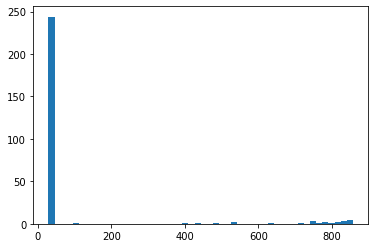

In [85]:
_ = plt.hist(vw.get_frame_diffs(), 50)

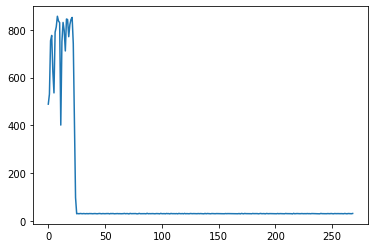

In [86]:
plt.plot(vw.get_frame_diffs())